## Data Preparation

In [97]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import scipy.io
from scipy.special import softmax
from sklearn.svm import SVC
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import copy
from sklearn.calibration import calibration_curve
from scipy import interpolate
import logging
import time
logger = logging.getLogger("fair")

In [2]:
path = r"..."
os.chdir(path)

In [3]:
X = pd.read_csv("synthetic_data_X.csv") 
Y = pd.read_csv("synthetic_data_Y.csv") 
z = pd.read_csv("sensitive.csv")
label = pd.read_csv("label.csv")

In [4]:
X.drop(columns=X.columns[0], inplace=True)
Y.drop(columns=Y.columns[0], inplace=True)
z.drop(columns=z.columns[0], inplace=True)
label.drop(columns=label.columns[0], inplace=True)

In [5]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,0.231833,0.067323,0.601193,0.129800,-0.197540,0.087016,-0.177555,-0.351037,-0.301460,-0.057862,...,-0.088177,0.196340,-0.453305,0.164936,-0.026206,-0.249087,-0.196344,0.550293,-0.105249,-0.239080
1,-0.294247,0.101822,-0.033049,-0.101412,-0.120017,0.348770,0.044132,-0.313527,-0.154874,0.133751,...,-0.127356,0.284231,-0.229541,0.049666,-0.210793,-0.047522,-0.111105,0.313510,-0.135614,-0.022544
2,-0.362530,-0.034981,-0.371719,-0.261221,0.115182,0.176349,-0.109677,0.135819,0.005883,0.022130,...,0.002416,0.058523,-0.043859,-0.058995,0.014325,0.165685,-0.257595,0.093505,0.085533,0.152656
3,-0.218923,-0.059219,-0.455640,0.065432,0.176740,-0.104267,0.214819,0.371585,0.316929,0.120349,...,0.119675,-0.122803,0.424549,-0.180956,-0.073814,0.167517,0.399852,-0.585392,0.131530,0.207197
4,0.014943,0.007254,-0.048290,-0.111945,-0.011746,0.020405,-0.015400,-0.060813,-0.030355,-0.037788,...,-0.033743,-0.032065,-0.003358,0.025402,0.052292,0.029138,-0.127120,0.051101,-0.040173,-0.002063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.114082,-0.151121,-0.159216,0.105603,0.249230,-0.185898,-0.173091,0.566061,0.181611,-0.028716,...,0.201632,-0.103343,0.100516,-0.151238,0.097535,0.120040,0.090909,-0.229248,0.321160,0.159661
496,0.741527,-0.099675,0.480324,0.782278,0.063522,-0.747811,0.269935,0.440145,0.384718,-0.038147,...,0.263928,-0.396075,0.544888,-0.106777,0.058135,-0.181596,0.993503,-0.894552,0.160933,-0.103597
497,0.063219,-0.061480,0.114065,-0.159840,0.048387,-0.012771,-0.323837,0.069673,-0.145439,-0.164242,...,0.012025,-0.025675,-0.252498,0.053547,0.205573,0.023503,-0.443064,0.351444,0.091578,-0.023345
498,0.369077,-0.052315,0.469234,-0.136257,-0.042971,-0.096724,-0.456055,-0.087796,-0.295629,-0.295553,...,-0.024363,-0.062777,-0.430969,0.163937,0.330195,-0.089857,-0.628060,0.599886,0.034746,-0.172660


In [6]:
Y.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,-0.350358,-0.494288,-0.101563,-0.116336,-0.067924,0.196027,-0.049688,-0.383029,0.532692,-0.145506,...,0.049599,0.406780,0.507896,-0.321379,-0.376660,0.243324,0.200197,-0.010141,-0.197722,0.107093
1,0.083419,0.101436,0.119462,-0.125624,0.358145,0.111752,0.035281,-0.198218,-0.061746,0.284161,...,-0.129471,-0.145216,-0.071335,0.047402,0.060053,0.192353,-0.018840,-0.060244,0.081771,0.019553
2,0.302781,0.317869,0.053526,-0.050046,0.232769,0.003385,0.116797,0.095482,0.086471,0.188548,...,-0.338896,-0.031668,0.104080,0.128411,0.038426,0.049675,0.138664,0.098581,-0.003071,0.014322
3,0.348007,0.410152,-0.005465,0.110242,-0.049697,-0.139849,0.107572,0.394407,-0.150885,0.013386,...,-0.240495,-0.105557,-0.132170,0.214816,0.169790,-0.250583,0.003963,0.118731,0.022074,-0.059402
4,0.165834,0.200000,-0.053965,0.124930,-0.271873,-0.419176,-0.068378,0.470327,0.229377,-0.253727,...,0.192184,0.111317,0.368121,0.108758,-0.062731,0.002085,0.334405,0.246663,-0.039710,0.020417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.205860,-0.030744,0.460610,-0.290547,0.726218,-0.461940,-0.448387,-0.401632,-0.201779,0.459940,...,1.103772,-0.602968,0.057723,0.126339,0.114674,1.111268,0.212201,-0.134666,0.492452,0.122255
496,-0.204388,-0.162960,-0.218950,0.361937,-0.935102,-0.601972,-0.240224,0.679524,0.007521,-0.754466,...,0.751179,0.175693,0.139745,-0.005665,-0.053881,-0.350434,0.105110,0.184095,-0.059556,-0.054554
497,0.080310,0.161635,-0.040882,0.194755,-0.364584,-0.423274,-0.109795,0.492212,-0.125448,-0.278004,...,0.360617,-0.069869,-0.019161,0.142688,0.096606,-0.163717,0.070627,0.132695,0.056068,-0.045852
498,-0.063566,-0.065559,0.024266,-0.035606,0.008049,-0.147379,-0.097315,-0.010223,0.189324,-0.047247,...,0.226076,0.056053,0.265009,-0.030178,-0.103658,0.229982,0.194855,0.058531,0.005924,0.053612


In [7]:
X = np.array(X)
Y = np.array(Y)

In [8]:
label = np.array(label)+1
z = np.array(z)+1

In [10]:
indice_female = []
indice_male = []   
index_male = np.where(z == 1)[0]
index_female = np.where(z == 2)[0]
matlab_indices = index_male + 1
matlab_indices = ','.join(map(str, matlab_indices))
matlab_indices

'1,2,4,5,7,8,10,11,12,13,14,15,17,18,19,20,21,22,24,25,26,27,28,30,32,33,34,35,36,38,39,41,42,43,44,46,48,49,50,51,53,54,57,58,59,60,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,81,82,83,84,87,88,89,90,92,93,94,95,96,97,98,100,101,102,105,106,107,109,110,111,112,113,114,116,117,118,120,121,122,124,125,127,128,129,131,132,133,134,136,139,141,143,144,145,147,148,149,151,152,153,154,157,158,159,160,161,163,164,166,167,168,169,170,171,172,174,176,178,179,180,181,182,184,185,186,187,191,193,194,195,196,197,198,200,201,202,203,204,205,208,209,210,213,216,218,219,220,221,222,223,224,225,226,227,228,229,231,232,233,235,236,237,238,239,240,241,242,243,246,247,248,249,250,251,253,255,257,259,260,261,262,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,281,282,283,284,286,287,288,290,291,293,294,295,299,301,302,303,304,305,308,309,310,312,313,314,315,316,317,318,319,320,321,322,324,325,328,329,330,331,333,334,335,336,337,338,339,340,342,343,344,345,346,347,348,349,350,352,353,35

## Algorithm for FRCCA

In [11]:
import numpy as np
from sklearn.cross_decomposition import CCA

class FairCCA:
    def __init__(self, R, scale=True, max_iter=int(1e4), tol=1e-10):
        self.R = R
        self.scale = scale
        self.max_iter = max_iter
        self.tol = tol
        self.R_x = None
        self.R_y = None
        self.cca = CCA(n_components=R, scale=scale, max_iter=max_iter, tol=tol)
        
    def fit(self, X, Y, z):
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        Y = (Y - Y.mean(axis=0)) / Y.std(axis=0)
        z = (z - z.mean()) / z.std()
        z = z.reshape(-1, 1)
        
        zX = z.T @ X
        _, _, Vt_x = np.linalg.svd(zX)
        self.R_x = Vt_x[:, 1:]
        
        zY = z.T @ Y
        _, _, Vt_y = np.linalg.svd(zY)
        self.R_y = Vt_y[:, 1:]
        
        X_new = X @ self.R_x
        Y_new = Y @ self.R_y
        
        self.cca.fit(X_new, Y_new)
        
    def transform(self, X, Y):
        X_new = (X - X.mean(axis=0)) / X.std(axis=0)
        Y_new = (Y - Y.mean(axis=0)) / Y.std(axis=0)
        X_transformed = X_new @ self.R_x
        Y_transformed = Y_new @ self.R_y
        X_c, Y_c = self.cca.transform(X_transformed, Y_transformed)
        X_c = X_c / (np.sqrt(np.sum(X_c**2, axis=0)))
        Y_c = Y_c / (np.sqrt(np.sum(Y_c**2, axis=0)))
        return X_c, Y_c
    
    def fit_transform(self, X, Y, z):
        self.fit(X, Y, z)
        return self.transform(X, Y)


## Baseline: Traditional CCA

In [12]:
corr_traditional_CCA_dim = []
fairness_traditional_CCA_dimX = []
fairness_traditional_CCA_dimY = []
for i in range(1, 5):
    cca = CCA(n_components=i)
    cca.fit(X,Y)
    X_c, Y_c = cca.transform(X, Y)
    X_c = X_c / (np.sqrt(np.sum(X_c**2, axis=0)))
    Y_c = Y_c / (np.sqrt(np.sum(Y_c**2, axis=0)))
    cov_trad_CCA = X_c.T@Y_c
    corr_trad_CCA = np.trace(cov_trad_CCA)
    corr_traditional_CCA_dim.append(corr_trad_CCA)
    fairness_traditional_CCAX = np.sum(np.abs(np.log(np.abs(z.T@X_c))))
    fairness_traditional_CCA_dimX.append(fairness_traditional_CCAX)
    fairness_traditional_CCAY = np.sum(np.abs(np.log(np.abs(z.T@Y_c))))
    fairness_traditional_CCA_dimY.append(fairness_traditional_CCAY)


corr_traditional_CCA_dim = np.array(corr_traditional_CCA_dim)
fairness_traditional_CCA_dimX = np.array(fairness_traditional_CCA_dimX)
fairness_traditional_CCA_dimY = np.array(fairness_traditional_CCA_dimY)
corr_traditional_CCA_dim, fairness_traditional_CCA_dimX, fairness_traditional_CCA_dimY

(array([0.86088997, 1.6940505 , 2.4396986 , 3.15861687]),
 array([0.21250878, 1.11489377, 1.9938742 , 2.42382116]),
 array([1.21002277, 4.68297534, 5.27707475, 5.48212539]))

## Fairness and Correlation for FRCCA

### Data collection

In [13]:
corr_FRCCA_dim = []
fairness_FRCCA_dimX = []
fairness_FRCCA_dimY = []
for i in range(1, 5):
    fair_cca = FairCCA(R=i)
    X_proj, Y_proj = fair_cca.fit_transform(X, Y, z)
    cov_FRCCA = X_proj.T@Y_proj
    corr_FRCCA = np.trace(cov_FRCCA)
    corr_FRCCA_dim.append(corr_FRCCA)
    fairness_FRCCAX= np.sum(np.abs(np.log(np.abs(z.T@X_proj))))
    fairness_FRCCA_dimX.append(fairness_FRCCAX)
    fairness_FRCCAY= np.sum(np.abs(np.log(np.abs(z.T@Y_proj))))
    fairness_FRCCA_dimY.append(fairness_FRCCAY)

corr_FRCCA_dim = np.array(corr_FRCCA_dim)
fairness_FRCCA_dimX= np.array(fairness_FRCCA_dimX)
fairness_FRCCA_dimY = np.array(fairness_FRCCA_dimY)
corr_FRCCA_dim, fairness_FRCCA_dimX, fairness_FRCCA_dimY

(array([0.85040746, 1.6785636 , 2.40269643, 3.08413301]),
 array([19.43651827, 41.30895886, 60.60520151, 77.23738744]),
 array([19.44250595, 38.80074305, 60.03078532, 74.34604407]))

### Plots

In [ ]:
from matplotlib.ticker import MaxNLocator
plt.rc('font', family='Times New Roman', weight='normal')
dimensions = np.array([1, 2, 3, 4])
corr_change = (corr_FRCCA_dim - corr_traditional_CCA_dim) / corr_traditional_CCA_dim 
fairnessX = (fairness_FRCCA_dimX - fairness_traditional_CCA_dimX) / fairness_traditional_CCA_dimX
fairnessY = (fairness_FRCCA_dimY - fairness_traditional_CCA_dimY) / fairness_traditional_CCA_dimY
fairness = (fairnessX + fairnessY) / 2
fig, ax = plt.subplots(figsize = (8,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18)  
# for label in ax.get_xticklabels():
#     label.set_weight('bold')  
# for label in ax.get_yticklabels():
#     label.set_weight('bold')  
fairness_bars = ax.bar(dimensions, fairness, width=0.4, color='#ff9549', label='Fairness')


correlation_bars = ax.bar(dimensions + 0.4, corr_change * 500, width=0.4, color='lightblue', label='Correlation')


for bar in fairness_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=24)

for bar in correlation_bars:
    yval = bar.get_height()
    yval_2 = yval / 500
    if yval <= 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='top', fontsize=24)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='bottom', fontsize=24)
ax.set_ylim(-20, 60)        
ticks = np.array(ax.get_yticks())

ticks_to_change = ticks == -20

ticks[ticks_to_change] = -0.01

ax.set_yticklabels(ticks)
plt.grid(False)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=1.5, color='grey')
ax.set_xlabel('Dimension', fontsize=24, fontweight='bold')
ax.set_ylabel('Percentage Change', fontsize=24, fontweight='bold')
#ax.set_title('Fairness and Correlation by Dimension', fontsize = 18)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


plt.show()


## Fairness and Correlation for SFCCA

### Data Collection

In [15]:
corr_SFCCA_dim = []
fairness_SFCCA_dimX = []
fairness_SFCCA_dimY = []
for i in range(1, 5):
    address = fr"..."
    mat = scipy.io.loadmat(address)
    U = mat[f'U_SF']
    V = mat[f'V_SF']
    X_proj = X@U
    Y_proj = Y@V
    X_proj = X_proj / (np.sqrt(np.sum(X_proj**2, axis=0)))
    Y_proj = Y_proj / (np.sqrt(np.sum(Y_proj**2, axis=0)))
    cov_SFCCA = X_proj.T@Y_proj
    corr_SFCCA = np.trace(cov_SFCCA)
    corr_SFCCA_dim.append(corr_SFCCA)
    fairness_SFCCAX= np.sum(np.abs(np.log(np.abs(z.T@X_proj))))
    fairness_SFCCA_dimX.append(fairness_SFCCAX)
    fairness_SFCCAY= np.sum(np.abs(np.log(np.abs(z.T@Y_proj))))
    fairness_SFCCA_dimY.append(fairness_SFCCAY)

corr_SFCCA_dim = np.abs(np.array(corr_SFCCA_dim))
fairness_SFCCA_dimX= np.array(fairness_SFCCA_dimX)
fairness_SFCCA_dimY = np.array(fairness_SFCCA_dimY)
corr_SFCCA_dim, fairness_SFCCA_dimX, fairness_SFCCA_dimY

(array([0.84566917, 1.66993436, 2.38561511, 3.07062383]),
 array([1.67904399, 2.21974361, 2.75353881, 2.93968773]),
 array([0.8813568 , 1.66216016, 2.74997617, 3.48148984]))

### Plots

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.rc('font', family='Times New Roman', weight='normal')
dimensions = np.array([1, 2, 3, 4])
corr_change = (corr_FRCCA_dim - corr_SFCCA_dim) / corr_SFCCA_dim 
fairnessX = (fairness_FRCCA_dimX - fairness_SFCCA_dimX) / fairness_SFCCA_dimX
fairnessY = (fairness_FRCCA_dimY - fairness_SFCCA_dimY) / fairness_SFCCA_dimY
fairness = (fairnessX + fairnessY) / 2
fig, ax = plt.subplots(figsize = (8,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18)  
# for label in ax.get_xticklabels():
#     label.set_weight('bold')  
# for label in ax.get_yticklabels():
#     label.set_weight('bold')  
fairness_bars = ax.bar(dimensions, fairness, width=0.4, color='#ff9549', label='Fairness')


correlation_bars = ax.bar(dimensions + 0.4, corr_change*200, width=0.4, color='lightblue', label='Correlation')


for bar in fairness_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=24)

for bar in correlation_bars:
    yval = bar.get_height()
    yval_2 = yval/200
    if yval <= 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='top', fontsize = 24)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='bottom', fontsize=24)
ax.set_ylim(-1, 26)        
ticks = np.array(ax.get_yticks())

ticks_to_change = ticks == -10

ticks[ticks_to_change] = -0.05

ax.set_yticklabels(ticks)
plt.grid(False)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=1.5, color='grey')
ax.set_xlabel('Dimension', fontsize=24, fontweight='bold')
ax.set_ylabel('Percentage Change',fontsize=24, fontweight='bold')
#ax.set_title('Fairness and Correlation by Dimension', fontsize = 18)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

#ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3, fontsize=14)
#ax.legend(fontsize = 18, fancybox=True)

plt.show()


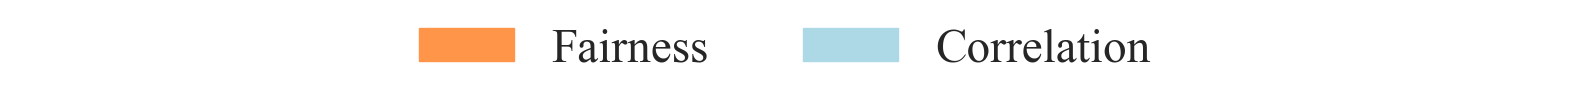

In [95]:
patch1 = patches.Patch(color='#ff9549', label='Fairness')
patch2 = patches.Patch(color='lightblue', label='Correlation')
plt.rc('font', family='Times New Roman', weight='normal')
plt.figure(figsize=(20, 0.1))
plt.axis('off')

plt.legend(handles=[patch1, patch2], loc='center', ncol=2, frameon=False, fontsize=34)

plt.show()

## Fairness and Correlation for MFCCA

### Data Collection

In [18]:
corr_MFCCA_dim = []
fairness_MFCCA_dimX = []
fairness_MFCCA_dimY = []
for i in range(1, 5):
    address = fr"..."
    mat = scipy.io.loadmat(address)
    U = mat[f'U_MF']
    V = mat[f'V_MF']
    X_proj = X@U
    Y_proj = Y@V
    X_proj = X_proj / (np.sqrt(np.sum(X_proj**2, axis=0)))
    Y_proj = Y_proj / (np.sqrt(np.sum(Y_proj**2, axis=0)))
    cov_MFCCA = X_proj.T@Y_proj
    corr_MFCCA = np.trace(cov_MFCCA)
    corr_MFCCA_dim.append(corr_MFCCA)
    fairness_MFCCAX= np.sum(np.abs(np.log(np.abs(z.T@X_proj))))
    fairness_MFCCA_dimX.append(fairness_MFCCAX)
    fairness_MFCCAY= np.sum(np.abs(np.log(np.abs(z.T@Y_proj))))
    fairness_MFCCA_dimY.append(fairness_MFCCAY)

corr_MFCCA_dim = np.abs(np.array(corr_MFCCA_dim))
fairness_MFCCA_dimX= np.array(fairness_MFCCA_dimX)
fairness_MFCCA_dimY = np.array(fairness_MFCCA_dimY)
corr_MFCCA_dim, fairness_MFCCA_dimX, fairness_MFCCA_dimY

(array([0.85465515, 1.68572823, 2.41566681, 3.12638881]),
 array([1.46485142, 1.76044868, 2.17290401, 2.4071758 ]),
 array([0.79237527, 1.6665283 , 2.83215772, 3.69152987]))

### Plot

In [ ]:
from matplotlib.ticker import MaxNLocator

plt.rc('font', family='Times New Roman', weight='normal')
dimensions = np.array([1, 2, 3, 4])
corr_change = (corr_FRCCA_dim - corr_MFCCA_dim) / corr_MFCCA_dim 
fairnessX = (fairness_FRCCA_dimX - fairness_MFCCA_dimX) / fairness_MFCCA_dimX
fairnessY = (fairness_FRCCA_dimY - fairness_MFCCA_dimY) / fairness_MFCCA_dimY
fairness = (fairnessX + fairnessY) / 2
fig, ax = plt.subplots(figsize = (8,5))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='x', labelsize=18)  
ax.tick_params(axis='y', labelsize=18)  
# for label in ax.get_xticklabels():
#     label.set_weight('bold')  
# for label in ax.get_yticklabels():
#     label.set_weight('bold')  
fairness_bars = ax.bar(dimensions, fairness, width=0.4, color='#ff9549', label='Fairness')


correlation_bars = ax.bar(dimensions + 0.4, corr_change * 500, width=0.4, color='lightblue', label='Correlation')


for bar in fairness_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=24)

for bar in correlation_bars:
    yval = bar.get_height()
    yval_2 = yval / 500
    if yval <= 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='top', fontsize=24)
    else:
        plt.text(bar.get_x() + bar.get_width()/2, yval , f"{yval_2:.3f}", ha='center', va='bottom', fontsize=24)
ax.set_ylim(-10, 26)        
ticks = np.array(ax.get_yticks())

ticks_to_change = ticks == -10

ticks[ticks_to_change] = -0.02

ax.set_yticklabels(ticks)
plt.grid(False)
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=1.5, color='grey')
ax.set_xlabel('Dimension', fontsize=24, fontweight='bold')
ax.set_ylabel('Percentage Change',fontsize=24, fontweight='bold')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.show()


# Fairness Metrics

In [20]:
def demographic_parity_multiclass_PR(y_hat, sensitive_features, class_idx):
        # measure the difference between the positive rates (TPR+FPR) of different groups
    y_hat = y_hat.ravel()
    values_of_sensible_feature = np.unique(sensitive_features)
    #print(values_of_sensible_feature)
    all_positive = np.sum([1.0 if y_hat[i] == class_idx else 0.0 for i in range(len(y_hat))])
    all_positive_rate = all_positive / len(y_hat)
    female_category = values_of_sensible_feature[0]
    male_category = values_of_sensible_feature[1]
    positive_female = np.sum([1.0 if sensitive_features[i] == female_category and y_hat[i] == class_idx 
                              else 0.0 for i in range(len(y_hat))])
    female_num = np.sum([1.0 if sensitive_features[i] == female_category else 0.0 for i in range(len(y_hat))])
    positive_rate_female = positive_female / female_num
        
        
    positive_male = np.sum([1.0 if sensitive_features[i] == male_category and y_hat[i] == class_idx 
                            else 0.0 for i in range(len(y_hat))])
    male_num = np.sum([1.0 if sensitive_features[i] == male_category else 0.0 for i in range(len(y_hat))])
    positive_rate_male = positive_male / male_num
    
    return np.abs(positive_rate_male - positive_rate_female)
    

In [21]:
def standard_suf_gap_all_class_wise(y, y_hat, A, class_idx=1):
    #y_hat = y_hat.ravel()
    num_A = len(np.unique(A))
    n_bins = 12
    interpolate_kind = 'linear'
    #print(y_hat.shape)
    #y_hat = softmax(y_hat, axis=1)  # normalize
   
    y_hat = y_hat[:,class_idx]  # choose the specific column (class)

    y_temp = copy.copy(y)
    y_temp[np.where(y != class_idx)[0]] = 0  # make all the other classes as 0
    y_temp[np.where(y == class_idx)[0]] = 1  # make the specific class as 1
    y = y_temp

    all_prob_true, all_prob_pred = calibration_curve(y, y_hat, n_bins=n_bins, pos_label=1)

    if all_prob_true.shape[0] != n_bins:
        logger.info('The range of prediction is not large enough for sufficiency gap computation, shrink the bins!')
    n_bins = all_prob_true.shape[0]
    groups_pred_true = np.zeros((num_A, n_bins))
    groups_pred_prob = np.zeros((num_A, n_bins))

    for i in range(len(np.unique(A))):
        try:
            t, p = calibration_curve(
                y[A == np.unique(A)[i]], y_hat[A == np.unique(A)[i]], n_bins=n_bins)
            if interpolate_kind:
                new_x = all_prob_pred
                f = interpolate.interp1d(
                    p,
                    t,
                    bounds_error=False,
                    fill_value=(t[0], t[-1]),
                    kind=interpolate_kind,
                )
                t = f(new_x)
                p = new_x
            groups_pred_true[i] = t
            groups_pred_prob[i] = p
        except:
            continue
    exp_x_given_a = np.abs(all_prob_true - groups_pred_true).mean(axis=1)
    exp_x_a = exp_x_given_a.mean()

    return exp_x_a

In [22]:
def equalized_odds_class_wise(y, y_hat, sensitive_features, class_idx):
    # measure the difference between the true positive rates of different groups
    y_hat = y_hat.ravel()
    y = y.ravel()
    sensitive_features = sensitive_features.ravel()
    #y_hat = y_hat.argmax(1)
    # print(y_hat)
    # print(y)
    group_true_pos_r = []
    values_of_sensible_feature = np.unique(sensitive_features)
    #print(values_of_sensible_feature)
    true_positive = np.sum([1.0 if (y_hat[i] == class_idx and y[i] == class_idx)
                             else 0.0 for i in range(len(y_hat))])
    #print(true_positive)
    all_positive = np.sum([1.0 if y[i] == class_idx else 0.0 for i in range(len(y))])
    all_true_pos_r = true_positive / all_positive
    #print(all_true_pos_r)
    for val in values_of_sensible_feature:
        positive_sensitive = np.sum([1.0 if (sensitive_features[i] == val) & (y[i] == class_idx)
                                     else 0.0 for i in range(len(y_hat))])
        if positive_sensitive > 0:
            true_positive_sensitive = np.sum([1.0 if y_hat[i] == class_idx and
                        sensitive_features[i] == val and y[i] == class_idx
                         else 0.0 for i in range(len(y_hat))])
            eo_tmp = true_positive_sensitive / positive_sensitive  # true positive rate
            group_true_pos_r.append(eo_tmp)
            
    return np.mean(np.abs(all_true_pos_r - group_true_pos_r))

# Hyperparameter Tuning

In [ ]:
import scipy.stats as stats

In [23]:
label = label.ravel()
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, label,
                                                                            indices, test_size=0.3,
                                                                            random_state=0, stratify=label)
Y_train, Y_test = Y[idx_train], Y[idx_test]
z_train, z_test = z[idx_train], z[idx_test]
fair_cca = FairCCA(R=2)
fair_cca.fit(X_train, Y_train, z_train)
Y_train, X_train = fair_cca.transform(X_train, Y_train)
Y_test, X_test = fair_cca.transform(X_test, Y_test)
param_distributions = {
    'C': stats.uniform(0.1, 200),  
    'gamma': ['scale', 'auto'] + list(stats.uniform(0.1, 200).rvs(size=1000)), 
    'coef0': stats.uniform(0, 50), 
    'kernel': ['rbf', 'sigmoid']
}
model = SVC(probability=True)
cv = StratifiedKFold(n_splits=5)
random_search = RandomizedSearchCV(model, param_distributions, cv=cv, verbose=0, scoring='accuracy')
random_search.fit(X_train, y_train)
best_dp = float('inf')
best_gs = float('inf')
best_eo = float('inf')
best_model_dp = None
best_model_gs = None
best_model_eo = None
for model in random_search.cv_results_['params']:
    model_instance = SVC(**model, probability=True).fit(X_train, y_train)
    y_pred = model_instance.predict(X_train)
    y_pred_prob = model_instance.predict_proba(X_train)
    y_train = y_train.ravel()
    EO_FR = []
    for i in range(1,3): 
        EO_FR.append(equalized_odds_class_wise(y_train, y_pred, sensitive_features=z_train, class_idx=i))
    EO_FR = np.mean(EO_FR)
    
    GS_FR = []
    for i in range(0,2): 
        GS_FR.append(standard_suf_gap_all_class_wise(y_train, y_pred_prob, A=z_train, class_idx=i))
    GS_FR = np.mean(GS_FR)
    
    DP_FR_pr = []
    for i in range(1,3):
        DP_FR_pr.append(demographic_parity_multiclass_PR(y_pred, z_train, class_idx=i))
    DP_FR_pr = np.mean(DP_FR_pr)
    if GS_FR < best_gs:
        best_gs = GS_FR
        best_model_gs = model_instance
    if EO_FR < best_eo:
        best_eo = EO_FR
        best_model_eo = model_instance
    if DP_FR_pr < best_dp:
        best_dp = DP_FR_pr
        best_model_dp = model_instance

In [98]:
label = label.ravel()
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, label,
                                                                            indices, test_size=0.3,
                                                                            random_state=1, stratify=label)
Y_train, Y_test = Y[idx_train], Y[idx_test]
z_train, z_test = z[idx_train], z[idx_test]
fair_cca = FairCCA(R=2)
fair_cca.fit(X_train, Y_train, z_train)
Y_train, X_train = fair_cca.transform(X_train, Y_train)
Y_test, X_test = fair_cca.transform(X_test, Y_test)
param_grid = {
    'C': [190, 31],
    'coef0': [15.0, 11],
    'gamma': [450 , 'auto'], 
    'kernel': ['rbf', 'sigmoid'] 
}

model = SVC(probability=True)
cv = StratifiedKFold(n_splits=5)
grid_search2 = GridSearchCV(model, param_grid, cv=cv, verbose=0, scoring='accuracy')
grid_search2.fit(X_train, y_train)

for model in grid_search2.cv_results_['params']:
    model_instance = SVC(**model, probability=True).fit(X_train, y_train)
    y_pred = model_instance.predict(X_train)
    y_pred_prob = model_instance.predict_proba(X_train)
    y_train = y_train.ravel()
    EO_FR = []
    for i in range(1,3): # 3-Classes
        EO_FR.append(equalized_odds_class_wise(y_train, y_pred, sensitive_features=z_train, class_idx=i))
    EO_FR = np.mean(EO_FR)
    
    GS_FR = []
    for i in range(0,2): # 3-Classes
        GS_FR.append(standard_suf_gap_all_class_wise(y_train, y_pred_prob, A=z_train, class_idx=i))
    GS_FR = np.mean(GS_FR)
    
    DP_FR_pr = []
    for i in range(1,3): # 3-Classes
        DP_FR_pr.append(demographic_parity_multiclass_PR(y_pred, z_train, class_idx=i))
    DP_FR_pr = np.mean(DP_FR_pr)
    if GS_FR < best_gs:
        best_gs = GS_FR
        best_model_gs = model_instance
    if EO_FR < best_eo:
        best_eo = EO_FR
        best_model_eo = model_instance
    if DP_FR_pr < best_dp:
        best_dp = DP_FR_pr
        best_model_dp = model_instance


In [99]:
grid_search2.best_estimator_

SVC(C=190, coef0=15.0, gamma=450, kernel='sigmoid', probability=True)

# Subsequent Classification

## Classifier Parameter Grid Setup

In [28]:
param_grid1 = {
    'C': [190],
    'coef0': [15],
    'gamma': [450],
    'kernel': ['sigmoid']
}

## Classification for FRCCA processed data

In [29]:
seeds = [42, 43, 44, 45, 46]
idx_train_all = []
idx_test_all = []
accuracy_FR = []
all_y_pred_FR = []
sensitive = []
all_y_test_FR = []
all_X_train = []
all_X_test = []
all_y_train = []
all_y_test = []
best_params = []
all_y_pred_prob_FR = []

In [32]:
for seed in seeds:
    label = label.ravel()
    indices = np.arange(X.shape[0])
    'Split the two modalities X, Y into Training set and Testing set'
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, label,
                                                                            indices, test_size=0.3,
                                                                            random_state=seed, stratify=label)
    Y_train, Y_test = Y[idx_train], Y[idx_test]
    z_train, z_test = z[idx_train], z[idx_test]
    all_X_train.append(X_train.tolist())
    all_X_test.append(X_test.tolist())
    all_y_train.append(y_train.tolist())
    all_y_test.append(y_test.tolist())
    'FRCCA on X_train/Y_train, and get the weights U/V'
    "X_train := Training Dataset of Modality X utilized in the classification by FRCCA,"
    "Y_train := Training Dataset of Modality Y utilized in the classification by FRCCA"
    fair_cca = FairCCA(R=2)
    fair_cca.fit(X_train, Y_train, z_train)
    Y_train, X_train = fair_cca.transform(X_train, Y_train)
    Y_test, X_test = fair_cca.transform(X_test, Y_test)
    'Store the index of the Training and Testing samples for further usage'
    idx_train_all.append(idx_train.tolist())
    idx_test_all.append(idx_test.tolist())
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = X_train / (np.sqrt(np.sum(X_train**2, axis=0)))
    Y_train = Y_train / (np.sqrt(np.sum(Y_train**2, axis=0)))
    X_test = X_test / (np.sqrt(np.sum(X_test**2, axis=0)))
    Y_test = Y_test / (np.sqrt(np.sum(Y_test**2, axis=0)))
    svc1 = SVC(random_state=seed, probability=True, class_weight = 'balanced')
    clf1 = GridSearchCV(svc1, param_grid1, n_jobs=None)
    clf1.fit(X_train, y_train)
    y_pred_FR = clf1.predict(X_test)
    all_y_pred_FR.append(y_pred_FR.tolist())
    all_y_test_FR.append(y_test.tolist())
    accuracy = accuracy_score(y_test, y_pred_FR)
    accuracy_FR.append(accuracy)
    sensitive.append(z[idx_test])
    best_param = clf1.best_params_
    best_params.append(best_param)
    y_pred_prob_FR = clf1.predict_proba(X_test)
    all_y_pred_prob_FR.append(y_pred_prob_FR.tolist())
accuracy_FR = np.array(accuracy_FR)
all_y_pred_prob_FR = np.array(all_y_pred_prob_FR)
all_y_pred_FR = np.array(all_y_pred_FR)
all_y_test_FR = np.array(all_y_test_FR)
all_X_train = np.array(all_X_train)
all_X_test = np.array(all_X_test)
all_y_train = np.array(all_y_train)
all_y_test = np.array(all_y_test)


## Classification for Traditional CCA processed data

In [35]:
accuracy_trad = []
all_y_pred_trad = []
all_y_test_trad = []
all_y_train_trad = []
all_X_train_trad = []
all_X_test_trad = []
all_y_pred_prob_trad = []

In [36]:
for i in range(len(seeds)):
    X_train, Y_train = X[idx_train_all[i]], Y[idx_train_all[i]]
    X_test, Y_test = X[idx_test_all[i]], Y[idx_test_all[i]]
    cca1 = CCA(n_components=2)
    cca1.fit(X_train, Y_train)
    X_train, Y_train = cca1.transform(X_train, Y_train)
    X_test, Y_test = cca1.transform(X_test, Y_test)
    X_test = X_test / (np.sqrt(np.sum(X_test**2, axis=0)))
    Y_test = Y_test / (np.sqrt(np.sum(Y_test**2, axis=0)))
    seed = seeds[i]
    X_train = X_train / (np.sqrt(np.sum(X_train**2, axis=0)))
    Y_train = Y_train / (np.sqrt(np.sum(Y_train**2, axis=0)))
    X_train_trad, y_train_trad = Y_train, label[idx_train_all[i]].ravel()
    idx_train = idx_train_all[i]
    idx_test = idx_test_all[i]
    X_test_trad = Y_test
    y_test_trad = label[idx_test].ravel()
    scaler = StandardScaler()
    X_train_trad = scaler.fit_transform(X_train_trad)
    X_test_trad = scaler.transform(X_test_trad)
    svc2 = SVC(random_state=seed, probability=True, class_weight = 'balanced')
    clf2 = GridSearchCV(svc2, param_grid1, n_jobs=None)
    clf2.fit(X_train_trad, y_train_trad)
    y_pred_trad = clf2.predict(X_test_trad)
    all_y_pred_trad.append(y_pred_trad.tolist())
    all_y_train_trad.append(y_train_trad.tolist())
    all_y_test_trad.append(y_test_trad.tolist())
    all_X_train_trad.append(X_train_trad.tolist())
    all_X_test_trad.append(X_test_trad.tolist())
    accuracy = accuracy_score(y_test_trad, y_pred_trad)
    accuracy_trad.append(accuracy)
    y_pred_prob_trad = clf2.predict_proba(X_test_trad)
    all_y_pred_prob_trad.append(y_pred_prob_trad.tolist())
accuracy_trad = np.array(accuracy_trad)
all_y_pred_trad = np.array(all_y_pred_trad)
all_y_train_trad = np.array(all_y_train_trad)
all_y_test_trad = np.array(all_y_test_trad)
all_X_train_trad = np.array(all_X_train_trad)
all_X_test_trad = np.array(all_X_test_trad)
all_y_pred_prob_trad = np.array(all_y_pred_prob_trad)
end_time_algo2 = time.time()

In [39]:
sensitive = np.array(sensitive)
sensitive.shape

(5, 150, 1)

## Classification for SFCCA

In [40]:
all_X_SFCCA = []
all_Y_SFCCA = []
for i in range(0,len(seeds)):
    address = fr"..."
    mat = scipy.io.loadmat(address)
    U = mat['U_SF']
    V = mat['V_SF']
    X_SFCCA = X@U
    Y_SFCCA = Y@V
    all_X_SFCCA.append(X_SFCCA.tolist())
    all_Y_SFCCA.append(Y_SFCCA.tolist())
all_X_SFCCA = np.array(all_X_SFCCA)
all_Y_SFCCA = np.array(all_Y_SFCCA)

In [41]:
accuracy_SFCCA = []
all_y_pred_SFCCA = []
all_y_test_SFCCA = []
all_y_train_SFCCA = []
all_X_train_SFCCA = []
all_X_test_SFCCA = []
all_y_pred_prob_SFCCA = []

In [42]:
for i in range(len(seeds)):
    seed = seeds[i]
    idx_train = idx_train_all[i]
    idx_test = idx_test_all[i]
    X_train_SFCCA = all_Y_SFCCA[i][idx_train]
    X_test_SFCCA = all_Y_SFCCA[i][idx_test]
    y_train_SFCCA = label[idx_train].ravel()
    y_test_SFCCA = label[idx_test].ravel()
    X_train_SFCCA = X_train_SFCCA / (np.sqrt(np.sum(X_train_SFCCA**2, axis=0)))
    X_test_SFCCA = X_test_SFCCA / (np.sqrt(np.sum(X_test_SFCCA**2, axis=0)))
    scaler = StandardScaler()
    X_train_SFCCA = scaler.fit_transform(X_train_SFCCA)
    X_test_SFCCA = scaler.transform(X_test_SFCCA)
    svc5 = SVC(random_state=seed, probability=True, class_weight = 'balanced')
    clf5 = GridSearchCV(svc5, param_grid1, n_jobs=None)
    time1 = time.time()
    clf5.fit(X_train_SFCCA, y_train_SFCCA)
    y_pred_SFCCA = clf5.predict(X_test_SFCCA)
    all_y_pred_SFCCA.append(y_pred_SFCCA.tolist())
    all_y_train_SFCCA.append(y_train_SFCCA.tolist())
    all_y_test_SFCCA.append(y_test_SFCCA.tolist())
    all_X_train_SFCCA.append(X_train_SFCCA.tolist())
    all_X_test_SFCCA.append(X_test_SFCCA.tolist())
    accuracy = accuracy_score(y_test_SFCCA, y_pred_SFCCA)
    accuracy_SFCCA.append(accuracy)
    y_pred_prob_SFCCA = clf5.predict_proba(X_test_SFCCA)
    all_y_pred_prob_SFCCA.append(y_pred_prob_SFCCA.tolist())
accuracy_SFCCA = np.array(accuracy_SFCCA)
all_y_pred_SFCCA = np.array(all_y_pred_SFCCA)
all_y_train_SFCCA = np.array(all_y_train_SFCCA)
all_y_test_SFCCA = np.array(all_y_test_SFCCA)
all_X_train_SFCCA = np.array(all_X_train_SFCCA)
all_X_test_SFCCA = np.array(all_X_test_SFCCA)
all_y_pred_prob_SFCCA = np.array(all_y_pred_prob_SFCCA)
end_time_algo3 = time.time()

## Classification for MFCCA

In [45]:
all_X_MFCCA = []
all_Y_MFCCA = []
for i in range(0,len(seeds)):
    address = fr"..."
    mat = scipy.io.loadmat(address)
    U = mat['U_MF']
    V = mat['V_MF']
    X_MFCCA = X@U
    Y_MFCCA = Y@V
    all_X_MFCCA.append(X_MFCCA.tolist())
    all_Y_MFCCA.append(Y_MFCCA.tolist())
all_X_MFCCA = np.array(all_X_MFCCA)
all_Y_MFCCA = np.array(all_Y_MFCCA)

In [46]:
accuracy_MFCCA = []
all_y_pred_MFCCA = []
all_y_test_MFCCA = []
all_y_train_MFCCA = []
all_X_train_MFCCA = []
all_X_test_MFCCA = []
all_y_pred_prob_MFCCA = []

In [47]:
start_time_algo4 = time.time()
for i in range(len(seeds)):
    seed = seeds[i]
    idx_train = idx_train_all[i]
    idx_test = idx_test_all[i]
    X_train_MFCCA = all_Y_MFCCA[i][idx_train]
    X_test_MFCCA = all_Y_MFCCA[i][idx_test]
    y_train_MFCCA = label[idx_train].ravel()
    y_test_MFCCA = label[idx_test].ravel()
    X_train_MFCCA = X_train_MFCCA / (np.sqrt(np.sum(X_train_MFCCA**2, axis=0)))
    X_test_MFCCA = X_test_MFCCA / (np.sqrt(np.sum(X_test_MFCCA**2, axis=0)))
    scaler = StandardScaler()
    X_train_MFCCA = scaler.fit_transform(X_train_MFCCA)
    X_test_MFCCA = scaler.transform(X_test_MFCCA)
    svc6 = SVC(random_state=seed, probability=True, class_weight = 'balanced')
    clf6 = GridSearchCV(svc6, param_grid1, n_jobs=None)
    clf6.fit(X_train_MFCCA, y_train_MFCCA)

    y_pred_MFCCA = clf6.predict(X_test_MFCCA)
    all_y_pred_MFCCA.append(y_pred_MFCCA.tolist())
    all_y_train_MFCCA.append(y_train_MFCCA.tolist())
    all_y_test_MFCCA.append(y_test_MFCCA.tolist())
    all_X_train_MFCCA.append(X_train_MFCCA.tolist())
    all_X_test_MFCCA.append(X_test_MFCCA.tolist())
    accuracy = accuracy_score(y_test_MFCCA, y_pred_MFCCA)
    accuracy_MFCCA.append(accuracy)
    y_pred_prob_MFCCA = clf6.predict_proba(X_test_MFCCA)
    all_y_pred_prob_MFCCA.append(y_pred_prob_MFCCA.tolist())
accuracy_MFCCA = np.array(accuracy_MFCCA)
all_y_pred_MFCCA = np.array(all_y_pred_MFCCA)
all_y_train_MFCCA = np.array(all_y_train_MFCCA)
all_y_test_MFCCA = np.array(all_y_test_MFCCA)
all_X_train_MFCCA = np.array(all_X_train_MFCCA)
all_X_test_MFCCA = np.array(all_X_test_MFCCA)
all_y_pred_prob_MFCCA = np.array(all_y_pred_prob_MFCCA)
end_time_algo4 = time.time()

In [49]:
accuracy_svm = []
all_y_pred_svm = []
all_y_test_svm = []
all_y_train_svm = []
all_X_train_svm = []
all_X_test_svm = []
all_y_pred_prob_svm = []

In [50]:
for i in range(len(seeds)):
    X_train, Y_train = Y[idx_train_all[i]], Y[idx_train_all[i]]
    X_test, Y_test = Y[idx_test_all[i]], Y[idx_test_all[i]]
    X_train = X_train / (np.sqrt(np.sum(X_train**2, axis=0)))
    Y_train = Y_train / (np.sqrt(np.sum(Y_train**2, axis=0)))
    X_test = X_test / (np.sqrt(np.sum(X_test**2, axis=0)))
    Y_test = Y_test / (np.sqrt(np.sum(Y_test**2, axis=0)))
    seed = seeds[i]
    X_train_svm, y_train_svm = X_train, label[idx_train_all[i]].ravel()
    idx_train = idx_train_all[i]
    idx_test = idx_test_all[i]
    X_test_svm = X_test
    y_test_svm = label[idx_test].ravel()
    scaler = StandardScaler()
    X_train_svm = scaler.fit_transform(X_train_svm)
    X_test_svm = scaler.transform(X_test_svm)
    svc7 = SVC(random_state=seed, probability=True, class_weight = 'balanced')
    clf7 = GridSearchCV(svc7, param_grid1, n_jobs=-1)
    clf7.fit(X_train_svm, y_train_svm)

    y_pred_svm = clf7.predict(X_test_svm)
    all_y_pred_svm.append(y_pred_svm.tolist())
    all_y_train_svm.append(y_train_svm.tolist())
    all_y_test_svm.append(y_test_svm.tolist())
    all_X_train_svm.append(X_train_svm.tolist())
    all_X_test_svm.append(X_test_svm.tolist())
    accuracy = accuracy_score(y_test_svm, y_pred_svm)
    accuracy_svm.append(accuracy)
    y_pred_prob_svm = clf7.predict_proba(X_test_svm)
    all_y_pred_prob_svm.append(y_pred_prob_svm.tolist())
accuracy_svm = np.array(accuracy_svm)
all_y_pred_svm = np.array(all_y_pred_svm)
all_y_train_svm = np.array(all_y_train_svm)
all_y_test_svm = np.array(all_y_test_svm)
all_X_train_svm = np.array(all_X_train_svm)
all_X_test_svm = np.array(all_X_test_svm)
all_y_pred_prob_svm = np.array(all_y_pred_prob_svm)
end_time_algo5 = time.time()

# Fairness Metrics for Each Algorithm

## FRCCA

### DPG

In [100]:
all_DP_FR_pr = []
for j in range(len(seeds)):
    DP_FR_pr = []
    for i in range(1,3): # 3-Classes
        DP_FR_pr.append(demographic_parity_multiclass_PR(all_y_pred_FR[j], sensitive[j], class_idx=i))
    DP_FR_pr = np.mean(DP_FR_pr)
    all_DP_FR_pr.append(DP_FR_pr)
all_DP_FR_pr = np.array(all_DP_FR_pr)
all_DP_FR_pr

array([0.04351204, 0.00847458, 0.01476301, 0.01614907, 0.10395538])

### EOG

In [101]:
all_EO_FR = []
for j in range(len(seeds)):
    EO_FR = []
    for i in range(1,3): # 3-Classes
        EO_FR.append(equalized_odds_class_wise(all_y_test_FR[j], all_y_pred_FR[j], sensitive_features=sensitive[j], class_idx=i))
    EO_FR = np.mean(EO_FR)
    all_EO_FR.append(EO_FR)
all_EO_FR = np.array(all_EO_FR)

### GSG

In [102]:
all_GS_FR = []
for j in range(len(seeds)):
    GS_FR = []
    for i in range(0,2): # 3-Classes
        GS_FR.append(standard_suf_gap_all_class_wise(all_y_test_FR[j], all_y_pred_prob_FR[j], A=sensitive[j], class_idx=i))
    GS_FR = np.mean(GS_FR)
    all_GS_FR.append(GS_FR)
all_GS_FR = np.array(all_GS_FR) 

## CCA

### DPG

In [103]:
all_DP_trad_pr = []
for j in range(len(seeds)):
    DP_trad_pr = []
    for i in range(1,3): # 3-Classes
        DP_trad_pr.append(demographic_parity_multiclass_PR(all_y_pred_trad[j], sensitive[j], class_idx=i))
    DP_trad_pr = np.mean(DP_trad_pr)
    all_DP_trad_pr.append(DP_trad_pr)
all_DP_trad_pr = np.array(all_DP_trad_pr)
all_DP_trad_pr

array([0.04195804, 0.08474576, 0.06682207, 0.17639752, 0.12271805])

### EOG

In [104]:
all_EO_trad = []
for j in range(len(seeds)):
    EO_trad = []
    for i in range(1,3): # 3-Classes
        EO_trad.append(equalized_odds_class_wise(all_y_test_trad[j], all_y_pred_trad[j], sensitive_features=sensitive[j], class_idx=i))
    EO_trad = np.mean(EO_trad)
    all_EO_trad.append(EO_trad)
all_EO_trad = np.array(all_EO_trad)


### GSG

In [105]:
all_GS_trad = []
for j in range(len(seeds)):
    GS_trad = []
    for i in range(0,2): # 3-Classes
        GS_trad.append(standard_suf_gap_all_class_wise(all_y_test_trad[j], all_y_pred_prob_trad[j], A=sensitive[j], class_idx=i))
    GS_trad = np.mean(GS_trad)
    all_GS_trad.append(GS_trad)
all_GS_trad = np.array(all_GS_trad) 

## SFCCA

### DPG

In [106]:
all_DP_SFCCA_pr = []
for j in range(len(seeds)):
    DP_SFCCA_pr = []
    for i in range(1,3): # 3-Classes
        DP_SFCCA_pr.append(demographic_parity_multiclass_PR(all_y_pred_SFCCA[j], sensitive[j], class_idx=i))
    DP_SFCCA_pr = np.mean(DP_SFCCA_pr)
    all_DP_SFCCA_pr.append(DP_SFCCA_pr)
all_DP_SFCCA_pr = np.array(all_DP_SFCCA_pr)
all_DP_SFCCA_pr

array([0.1017871 , 0.13612288, 0.002331  , 0.08198758, 0.17799189])

### EOG

In [107]:
all_EO_SFCCA = []
for j in range(len(seeds)):
    EO_SFCCA = []
    for i in range(1,3): # 3-Classes
        EO_SFCCA.append(equalized_odds_class_wise(all_y_test_SFCCA[j], all_y_pred_SFCCA[j], sensitive_features=sensitive[j], class_idx=i))
    EO_SFCCA = np.mean(EO_SFCCA)
    all_EO_SFCCA.append(EO_SFCCA)
all_EO_SFCCA = np.array(all_EO_SFCCA)

### GSG

In [108]:
all_GS_SF = []
for j in range(len(seeds)):
    GS_SF = []
    for i in range(0,2): # 3-Classes
        GS_SF.append(standard_suf_gap_all_class_wise(all_y_test_SFCCA[j], all_y_pred_prob_SFCCA[j], A=sensitive[j], class_idx=i))
    GS_SF = np.mean(GS_SF)
    all_GS_SF.append(GS_SF)
all_GS_SF = np.array(all_GS_SF) 

## MFCCA

### DPG

In [109]:
all_DP_MFCCA_pr = []
for j in range(len(seeds)):
    DP_MFCCA_pr = []
    for i in range(1,3): # 3-Classes
        DP_MFCCA_pr.append(demographic_parity_multiclass_PR(all_y_pred_MFCCA[j], sensitive[j], class_idx=i))
    DP_MFCCA_pr = np.mean(DP_MFCCA_pr)
    all_DP_MFCCA_pr.append(DP_MFCCA_pr)
all_DP_MFCCA_pr = np.array(all_DP_MFCCA_pr)
all_DP_MFCCA_pr

array([0.04972805, 0.19597458, 0.04972805, 0.13913043, 0.0831643 ])

### EOG

In [110]:
all_EO_MFCCA = []
for j in range(len(seeds)):
    EO_MFCCA = []
    for i in range(1,2): # 3-Classes
        EO_MFCCA.append(equalized_odds_class_wise(all_y_test_MFCCA[j], all_y_pred_MFCCA[j], sensitive_features=sensitive[j], class_idx=i))
    EO_MFCCA= np.mean(EO_MFCCA)
    all_EO_MFCCA.append(EO_MFCCA)
all_EO_MFCCA = np.array(all_EO_MFCCA)

### GSG

In [111]:
all_GS_MF = []
for j in range(len(seeds)):
    GS_MF = []
    for i in range(0,2): # 3-Classes
        GS_MF.append(standard_suf_gap_all_class_wise(all_y_test_MFCCA[j], all_y_pred_prob_MFCCA[j], A=sensitive[j], class_idx=i))
    GS_MF = np.mean(GS_MF)
    all_GS_MF.append(GS_MF)
all_GS_MF = np.array(all_GS_MF) 

## SVM

### DPG

In [112]:
all_DP_svm_pr = []
for j in range(len(seeds)):
    DP_svm_pr = []
    for i in range(1,3): # 3-Classes
        DP_svm_pr.append(demographic_parity_multiclass_PR(all_y_pred_svm[j], sensitive[j], class_idx=i))
    DP_svm_pr = np.mean(DP_svm_pr)
    all_DP_svm_pr.append(DP_svm_pr)
all_DP_svm_pr = np.array(all_DP_svm_pr)
all_DP_svm_pr

array([0.01476301, 0.15625   , 0.01554002, 0.02360248, 0.1627789 ])

### EOG

In [113]:
all_EO_svm = []
for j in range(len(seeds)):
    EO_svm = []
    for i in range(1,2): # 3-Classes
        EO_svm.append(equalized_odds_class_wise(all_y_test_svm[j], all_y_pred_svm[j], sensitive_features=sensitive[j], class_idx=i))
    EO_svm= np.mean(EO_svm)
    all_EO_svm.append(EO_svm)
all_EO_svm = np.array(all_EO_svm)

### GSG

In [114]:
all_GS_svm = []
for j in range(len(seeds)):
    GS_svm = []
    for i in range(0,2): # 3-Classes
        GS_svm.append(standard_suf_gap_all_class_wise(all_y_test_svm[j], all_y_pred_prob_svm[j], A=sensitive[j], class_idx=i))
    GS_svm = np.mean(GS_svm)
    all_GS_svm.append(GS_svm)
all_GS_svm = np.array(all_GS_svm)

# Comparison Plot

In [115]:
DP_FRCCA_std = np.std(all_DP_FR_pr)
DP_trad_std = np.std(all_DP_trad_pr)
DP_SFCCA_std = np.std(all_DP_SFCCA_pr)
DP_MFCCA_std = np.std(all_DP_MFCCA_pr)
DP_svm_std = np.std(all_DP_svm_pr)

EO_FRCCA_std = np.std(all_EO_FR)
EO_trad_std = np.std(all_EO_trad)
EO_SFCCA_std = np.std(all_EO_SFCCA)
EO_MFCCA_std = np.std(all_EO_MFCCA)
EO_svm_std = np.std(all_EO_svm)

accuracy_FR_std = np.std(accuracy_FR)
accuracy_trad_std = np.std(accuracy_trad)
accuracy_SFCCA_std = np.std(accuracy_SFCCA)
accuracy_MFCCA_std = np.std(accuracy_MFCCA)
accuracy_svm_std = np.std(accuracy_svm)

GS_FR_std = np.std(all_GS_FR)
GS_trad_std = np.std(all_GS_trad)
GS_SFCCA_std = np.std(all_GS_SF)
GS_MFCCA_std = np.std(all_GS_MF)
GS_svm_std = np.std(all_GS_svm)

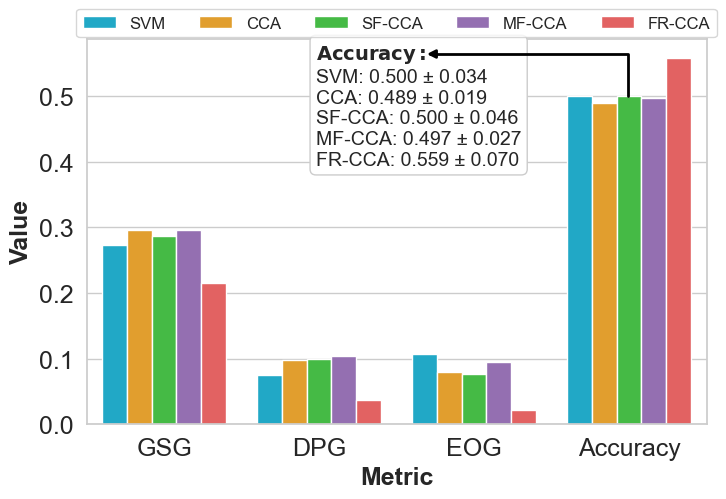

In [116]:
DP_FRCCA_mean = np.mean(all_DP_FR_pr)
DP_trad_mean = np.mean(all_DP_trad_pr)
DP_SFCCA_mean = np.mean(all_DP_SFCCA_pr)
DP_MFCCA_mean = np.mean(all_DP_MFCCA_pr)
DP_svm_mean = np.mean(all_DP_svm_pr)

EO_FRCCA_mean = np.mean(all_EO_FR)
EO_trad_mean = np.mean(all_EO_trad)
EO_SFCCA_mean = np.mean(all_EO_SFCCA)
EO_MFCCA_mean = np.mean(all_EO_MFCCA)
EO_svm_mean = np.mean(all_EO_svm)

accuracy_FR_mean = np.mean(accuracy_FR)
accuracy_trad_mean = np.mean(accuracy_trad)
accuracy_SFCCA_mean = np.mean(accuracy_SFCCA)
accuracy_MFCCA_mean = np.mean(accuracy_MFCCA)
accuracy_svm_mean = np.mean(accuracy_svm)

GS_FR_mean = np.mean(all_GS_FR)
GS_trad_mean = np.mean(all_GS_trad)
GS_SFCCA_mean = np.mean(all_GS_SF)
GS_MFCCA_mean = np.mean(all_GS_MF)
GS_svm_mean = np.mean(all_GS_svm)
data = {
    'Algorithm': ['SVM', 'SVM', 'SVM', 'SVM',
                  'CCA',  'CCA',  'CCA',  'CCA',
                  'SF-CCA','SF-CCA','SF-CCA','SF-CCA',
                  'MF-CCA','MF-CCA','MF-CCA','MF-CCA',
                  'FR-CCA', 'FR-CCA', 'FR-CCA','FR-CCA'
                 
                  
                  
                  ],
    'Metric': ['GSG', 'DPG', 'EOG', 'Accuracy',
               'GSG', 'DPG', 'EOG', 'Accuracy', 
               'GSG', 'DPG', 'EOG', 'Accuracy',
               'GSG', 'DPG', 'EOG', 'Accuracy',
               'GSG', 'DPG', 'EOG', 'Accuracy'
               ],
    'Value': [GS_svm_mean, DP_svm_mean, EO_svm_mean, accuracy_svm_mean,
              GS_trad_mean, DP_trad_mean, EO_trad_mean, accuracy_trad_mean,   
              GS_SFCCA_mean, DP_SFCCA_mean, EO_SFCCA_mean, accuracy_SFCCA_mean,
              GS_MFCCA_mean, DP_MFCCA_mean, EO_MFCCA_mean, accuracy_MFCCA_mean,
              GS_FR_mean, DP_FRCCA_mean, EO_FRCCA_mean, accuracy_FR_mean
              ]
              }
df = pd.DataFrame(data)

sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
barplot = sns.barplot(x='Metric', y='Value', hue='Algorithm', data=df,
                      palette=["#05b9e2", "#ffa510", "limegreen", "#9564bc", "#f74d4d"], alpha=1)

accuracy_values_with_std = {
    'SVM': f"{accuracy_svm_mean:.3f} ± {accuracy_svm_std:.3f}",
    'CCA': f"{accuracy_trad_mean:.3f} ± {accuracy_trad_std:.3f}",
    'SF-CCA': f"{accuracy_SFCCA_mean:.3f} ± {accuracy_SFCCA_std:.3f}",
    'MF-CCA': f"{accuracy_MFCCA_mean:.3f} ± {accuracy_MFCCA_std:.3f}",
    'FR-CCA': f"{accuracy_FR_mean:.3f} ± {accuracy_FR_std:.3f}"
}

accuracy_text = "\n".join([f"{key}: {value}" for key, value in accuracy_values_with_std.items()])
accuracy_text = r"$\bf{Accuracy:}$" + "\n" + accuracy_text
plt.text(0.37, 0.99, accuracy_text, fontsize=14, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="#cccccc", facecolor="white"))
# for p in barplot.patches:
#     height = p.get_height()
#     barplot.text(p.get_x() + p.get_width() / 2., height, '{:1.3f}'.format(height), 
#             ha="center", va='bottom', fontsize=11)
plt.annotate('', xy=(0.53, 0.89), xytext=(0.785, 0.8),
             xycoords='figure fraction', textcoords='figure fraction',
            arrowprops=dict(arrowstyle='-|>', color='black',
                             connectionstyle='angle,angleA=90,angleB=0,rad=0',
                             lw=2))
#plt.title('Comparison of Algorithms on Different Metrics', fontsize=18)
plt.xlabel('Metric', fontsize=18, fontweight='bold')
plt.ylabel('Value', fontsize=18, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
legend = plt.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=5)

plt.show()

In [117]:
data1 = {
  'acc_svm': accuracy_svm,
  'gs_svm': all_GS_svm,
  'dp_svm': all_DP_svm_pr,
  'eo_svm': all_EO_svm,
  
  'acc_trad': accuracy_trad,
  'gs_trad': all_GS_trad,
  'dp_trad': all_DP_trad_pr,
  'eo_trad': all_EO_trad,
  
  'acc_SFCCA': accuracy_SFCCA,
  'gs_SFCCA': all_GS_SF,
  'dp_SFCCA': all_DP_SFCCA_pr,
  'eo_SFCCA': all_EO_SFCCA,
  
  'acc_MFCCA': accuracy_MFCCA,
  'gs_MFCCA': all_GS_MF,
  'dp_MFCCA': all_DP_MFCCA_pr,
  'eo_MFCCA': all_EO_MFCCA,
  
  'acc_FRCCA': accuracy_FR,
  'gs_FRCCA': all_GS_FR,
  'dp_FRCCA': all_DP_FR_pr,
  'eo_FRCCA': all_EO_FR,
}
df = pd.DataFrame(data1, index=['SVM', 'CCA', 'SFCCA', 'MFCCA', 'FRCCA'])
df.to_csv('Synthetic_Y.csv')